In [74]:
from functions import *

In [75]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
from rasterio.transform import from_origin
import shutil

# Load data

In [76]:
W = 256
source_path = '../data/raw/'
data_paths = ['lst', 'ndvi', 'wt', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
list_rgb = [True,False,False,False]

In [77]:
data, time_slots = load_data(dir_paths,W,list_rgb)

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [78]:
data_inputs = data[dir_paths[0]]
ndvi = data[dir_paths[1]]
data_targets = data[dir_paths[2]]
print('inputs shape:', data_inputs.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (108, 256, 256, 3) (125, 256, 256)
targets shape: (108, 256, 256)


In [67]:
start_date = '2013-03'
end_date = '2023-07'

# Generar el rango de fechas en formato YYYY-MM
date_range = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# Convertir a un array de numpy (opcional, si quieres un array en lugar de un pandas Index)
time_slots = date_range.to_numpy()
time_slots

array(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12', 

In [80]:
gdf_points = gpd.read_file('../data/external/wt_filtered/wt_filtered.geojson')
time_slots = gdf_points.time.dt.strftime("%Y-%m").unique()
months = gdf_points.time.dt.month.unique()

In [81]:
time_slots

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', 

# Delete unuseful data

In [70]:
'''new_inputs = []
new_targets = []
new_masked_inputs = []
del_indices = []
for index in range(0,data_inputs.shape[0]):
  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):
    new_inputs.append(data_inputs[index])
    new_targets.append(data_targets[index])
    new_masked_inputs.append(masked_inputs[index])
  else:
    del_indices.append(index)

new_inputs = np.array(new_inputs)
new_targets = np.array(new_targets)
new_masked_inputs = np.array(new_masked_inputs)
slots = np.delete(time_slots,del_indices)'''

'new_inputs = []\nnew_targets = []\nnew_masked_inputs = []\ndel_indices = []\nfor index in range(0,data_inputs.shape[0]):\n  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])\n\n  blacks = img_gray==0\n  percentage_b = np.sum(blacks)/blacks.size * 100\n\n  whites = img_gray>=240\n  percentage_w = np.sum(whites)/whites.size * 100\n\n  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):\n    new_inputs.append(data_inputs[index])\n    new_targets.append(data_targets[index])\n    new_masked_inputs.append(masked_inputs[index])\n  else:\n    del_indices.append(index)\n\nnew_inputs = np.array(new_inputs)\nnew_targets = np.array(new_targets)\nnew_masked_inputs = np.array(new_masked_inputs)\nslots = np.delete(time_slots,del_indices)'

Including NDVI data

In [82]:
del_indices = []
fixed_ndvi = []
for index in range(0,data_inputs.shape[0]):
  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  img_ndvi = ndvi[index]

  whites = np.isnan(img_ndvi)
  percentage_w_ndvi = np.sum(whites)/whites.size * 100

  if np.all(img_gray == 255) or np.all(img_gray == 0) or np.all(img_gray == img_gray[0,0]) or (percentage_b > 50) or (percentage_w > 50) \
    or np.all(np.isnan(img_ndvi)) or np.all(img_ndvi == img_ndvi[0,0]) or (percentage_w_ndvi > 50):
    del_indices.append(index)
  else:
    new_ndvi = np.where(whites, 0.0, img_ndvi) # process ndvi images to not have nans
    fixed_ndvi.append(new_ndvi)


In [83]:
fixed_ndvi = np.array(fixed_ndvi)

In [84]:
slots = np.delete(time_slots,del_indices)

In [85]:
len(slots)

21

# Mask Landsat data

In [86]:
# Selecciona la imagen en el índice 0 (la primera imagen)
river_mask = data_targets[0]  # Cambia el índice según sea necesario

# Imprimir la forma de la imagen seleccionada
print('Selected image shape:', river_mask.shape)

Selected image shape: (256, 256)


In [87]:
# Supongamos que river_mask es tu máscara de río de forma (height, width)
# y que quieres que tenga 3 canales (para las imágenes RGB de data_inputs)
river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
river_mask_expanded = np.repeat(river_mask_expanded, data_inputs.shape[-1], axis=-1)  # Expande a (height, width, 3)

# Aplica la máscara solo a las entradas (inputs)
masked_inputs = []

for i,input_img in enumerate(data_inputs):
  if i not in del_indices:
    masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
    masked_inputs.append(masked_input)

# Convierte de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)

# Verifica las formas
print('masked inputs shape:', masked_inputs.shape)

masked inputs shape: (21, 256, 256, 3)


# Mask NDVI data

In [88]:
masked_inputs_ndvi = []

for i,input_img in enumerate(fixed_ndvi):
    masked_input_ndvi = input_img * river_mask  # Aplica la máscara a los inputs
    masked_inputs_ndvi.append(masked_input_ndvi)

# Convierte de nuevo a arrays de numpy
masked_inputs_ndvi = np.array(masked_inputs_ndvi)

# Verifica las formas
print('masked inputs shape:', masked_inputs_ndvi.shape)

masked inputs shape: (21, 256, 256)


# Download preprocessed data

In [89]:
boiron = gpd.read_file('../data/external/swissTLMboiron')

bounds = boiron.total_bounds
# Definir la resolución
resolution = 30
x_min, y_min, x_max, y_max = bounds

transform = from_origin(x_min, y_max, resolution, resolution)  # Origen en la esquina superior izquierda

In [90]:
# Function to clear the contents of a directory
def clear_directory(directory):
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Error deleting {file_path}. Reason: {e}')

In [91]:
def save_raster(raster_array,filepath,shp):
  resolution = 30
  x_min, y_min, x_max, y_max = shp.total_bounds
  transform = from_origin(x_min, y_max, resolution, resolution)

  with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=raster_array.shape[0],
        width=raster_array.shape[1],
        count=len(raster_array.shape),
        dtype=raster_array.dtype,
        crs=shp.crs.to_string(),  # Ensure correct CRS
        transform=transform,
        nodata=0.0
) as dst:
    if len(raster_array.shape) == 3:
      dst.write(raster_array[:, :, 0], 1)  # Red channel
      dst.write(raster_array[:, :, 1], 2)  # Green channel
      dst.write(raster_array[:, :, 2], 3)  # Blue channel
    else:
      dst.write(raster_array, 1)

Clean preprocessed directories

In [92]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['wt', 'lst', 'ndvi', 'wt_interpolated','wt']#, 'lst/masked']
for d in data:
  dest_dir = os.path.join(preprocessed_data_path, d)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)
  if d == 'lst':
    dest_dir_m = os.path.join(dest_dir, 'masked')
    os.makedirs(dest_dir_m, exist_ok=True)
    clear_directory(dest_dir_m)

Copy preprocessed images

In [93]:
for d in data:
  source_dir = os.path.join(raw_data_path, d)
  dest_dir = os.path.join(preprocessed_data_path, d)

  # List all files in the source directory
  all_images = os.listdir(source_dir)
  count = 0
  # Loop through each file and check if it contains any of the slots
  for ind, image_file in enumerate(all_images):
      # Check if the image filename contains any of the time slots
      if any(slot in image_file for slot in slots):
          # Construct full file paths
          if d == 'ndvi':
            date = image_file.split('_')[1].split('.')[0]
            name = f'{dest_dir}/ndvi_{date}.tiff'
            save_raster(fixed_ndvi[count], name, boiron)
            print(f'Copied: ndvi_{date}, at {dest_dir}')
          else:
            dst_path = os.path.join(dest_dir, image_file)
            src_path = os.path.join(source_dir, image_file)
            # Copy the file to the destination folder
            shutil.copy(src_path, dst_path)
            print()
            print('Image', count)
            print(f'Copied: {image_file}, from {src_path}, to {dst_path}')

            if d == 'lst':
              date = image_file.split('_')[1].split('.')[0]
              name = f'{dest_dir}/masked/lst_masked_{date}.tiff'
              save_raster(masked_inputs[count], name, boiron)
              print(f'Copied: lst_masked_{date}')

          count+=1





Image 0
Copied: raster_mask_temp_2017-09.tif, from ../data/raw/wt/raster_mask_temp_2017-09.tif, to ../data/preprocessed/wt/raster_mask_temp_2017-09.tif

Image 1
Copied: raster_mask_temp_2012-04.tif, from ../data/raw/wt/raster_mask_temp_2012-04.tif, to ../data/preprocessed/wt/raster_mask_temp_2012-04.tif

Image 2
Copied: raster_mask_temp_2012-12.tif, from ../data/raw/wt/raster_mask_temp_2012-12.tif, to ../data/preprocessed/wt/raster_mask_temp_2012-12.tif

Image 3
Copied: raster_mask_temp_2012-07.tif, from ../data/raw/wt/raster_mask_temp_2012-07.tif, to ../data/preprocessed/wt/raster_mask_temp_2012-07.tif

Image 4
Copied: raster_mask_temp_2014-07.tif, from ../data/raw/wt/raster_mask_temp_2014-07.tif, to ../data/preprocessed/wt/raster_mask_temp_2014-07.tif

Image 5
Copied: raster_mask_temp_2016-03.tif, from ../data/raw/wt/raster_mask_temp_2016-03.tif, to ../data/preprocessed/wt/raster_mask_temp_2016-03.tif

Image 6
Copied: raster_mask_temp_2014-04.tif, from ../data/raw/wt/raster_mask_tem

CHECK

In [94]:
dir_paths = ['../data/preprocessed/ndvi']
W = 256
list_rgb = [False]
data, time_slots = load_data(dir_paths,W,list_rgb)

(16, 256, 256)
0


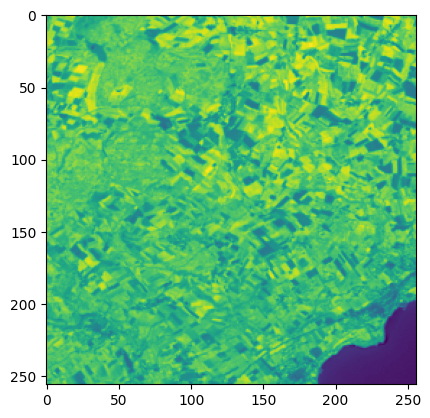

0


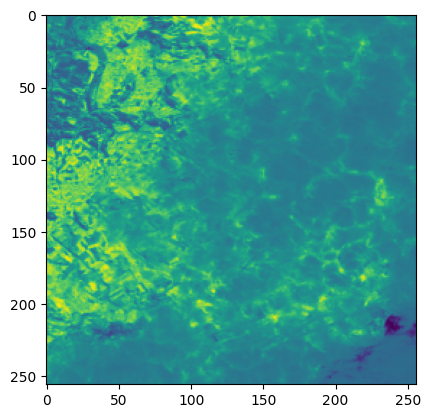

0


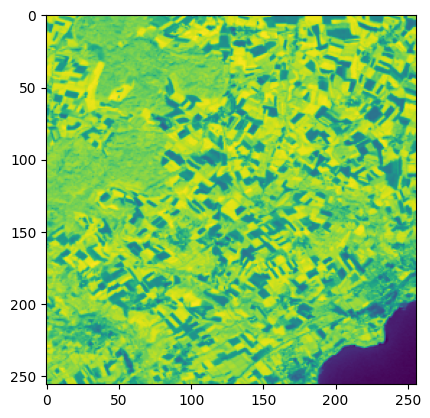

0


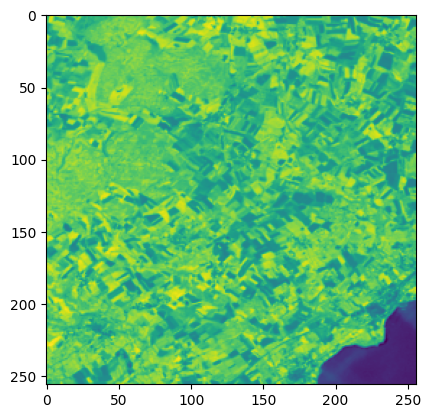

0


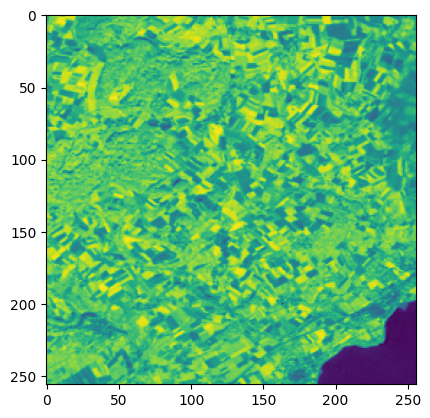

0


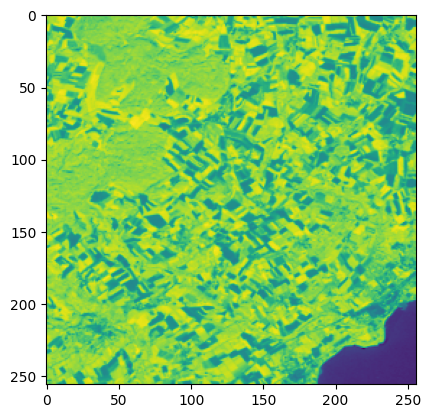

0


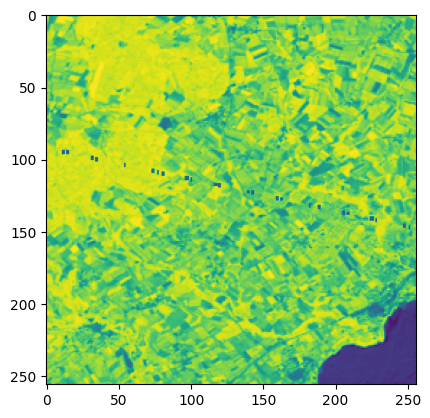

0


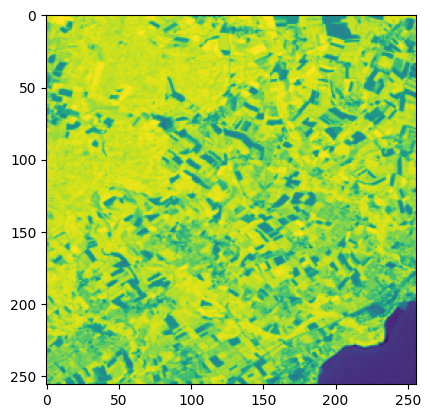

0


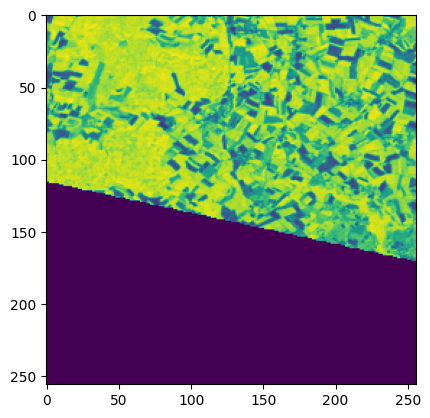

0


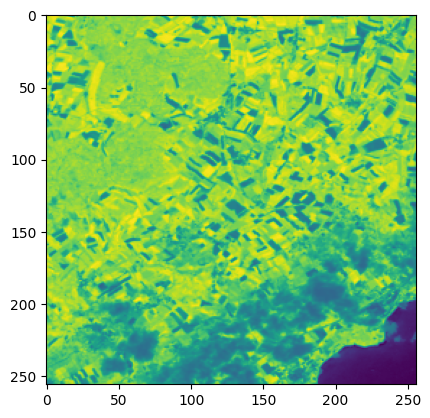

0


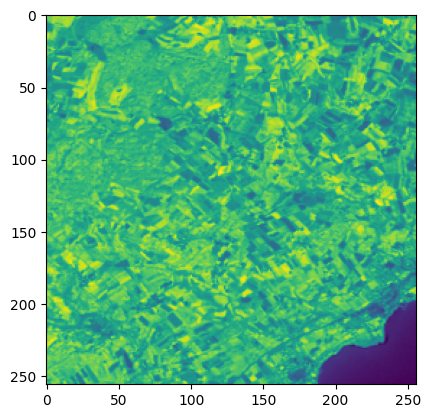

0


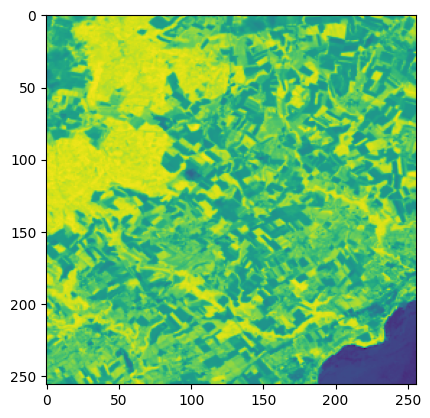

0


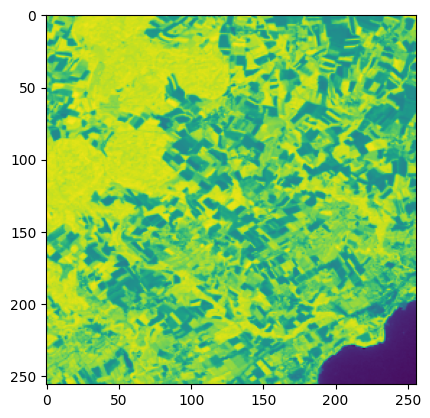

0


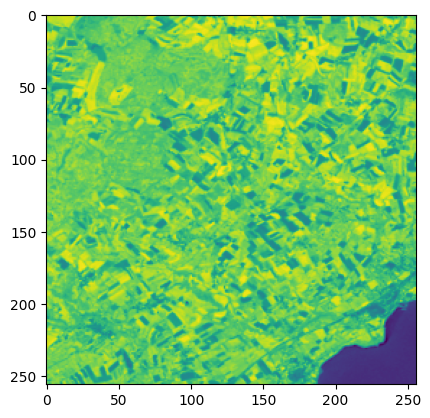

0


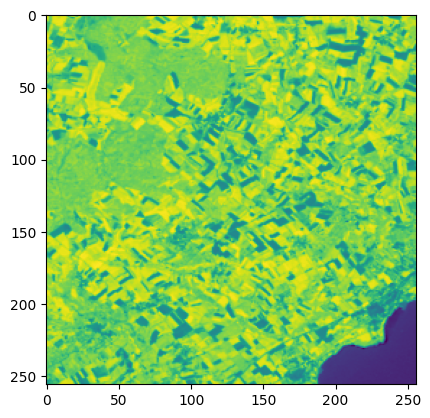

0


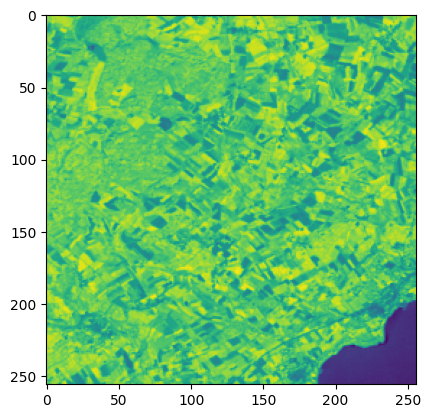

In [95]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(i)
  plt.show()

# Pixel wise dataset creation

In [96]:
river_indices = np.nonzero(river_mask.reshape(-1))[0]

In [97]:
len(river_indices)

4215

### LST dataset

In [98]:
pixel_ds_lst = pd.DataFrame(columns=[river_indices])
pixel_ds_lst

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [99]:
for i,image in enumerate(masked_inputs):
  img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution

  flat_image = img_gray.flatten()

  river_image = flat_image[river_indices]
  pixel_ds_lst.loc[slots[i]] = river_image

In [100]:
pixel_ds_lst

29         30         31         285        286       287    \
2011-04  16.393335  12.708776   7.313337  15.827381   8.294385  0.000178   
2012-04  61.266236  47.620025  27.673963  60.111527  31.417559  0.000670   
2012-07  58.687841  45.768314  26.588990  58.116454  30.482530  0.000650   
2012-09   2.349577   1.532386   0.897871   1.701855   0.850706  0.000018   
2012-12  58.104015  45.448988  26.701640  57.602499  30.227737  0.000647   
2013-07  40.919717  32.166547  18.992805  39.799000  20.983279  0.000453   
2014-02  43.159259  33.078996  19.005308  42.060504  21.975468  0.000470   
2014-04  72.471057  54.983968  31.939675  69.188311  36.224797  0.000771   
2014-07  71.353529  54.793125  31.794330  69.725097  36.351236  0.000771   
2014-08  56.390374  44.002667  25.782475  55.512061  29.136687  0.000625   
2015-06  63.120341  49.259814  28.647115  62.373031  32.752187  0.000698   
2015-12  47.916337  36.567872  21.087741  45.829939  23.788872  0.000504   
2016-03  44.835861  34.890171  20.261036  44.322006  23.310096  0.000500   
2016-09  45.648504  35.657043  20.880175  44.775240  23.335850  0.000499   
2016-11  11.783332   9.260437   5.292852  11.704007   6.167620  0.000132   
2017-02  42.472009  33.445469  19.645741  42.045501  22.288920  0.000479   
2017-05   8.451014   6.470208   3.742046   7.828160   4.125177  0.000088   
2017-09  65.647422  50.577653  29.357883  63.941683  33.460001  0.000712   
2017-11  11.066449   8.386160   4.864660  10.249679   5.487474  0.000119   
2019-01  39.324859  30.376452  17.603963  38.428225  20.061380  0.000431   
2019-06  58.363262  45.727776  26.626631  58.116453  30.625421  0.000655   

             541        542        797        798    ...      65207  \
2011-04   3.041926  12.100403  14.955146   5.010901  ...   2.925001   
2012-04  11.810758  45.785365  58.015296  18.917923  ...  50.565594   
2012-07  11.527297  45.057496  56.845432  18.605880  ...  46.599474   
2012-09   0.240152   0.938699   1.187647   0.388724  ...   5.887016   
2012-12  11.366727  44.220868  55.584560  18.199800  ...  30.693310   
2013-07   7.763977  30.347563  37.285605  12.203821  ...  21.613030   
2014-02   8.288998  32.228627  40.992362  13.346206  ...  29.025641   
2014-04  13.652136  53.192879  67.299969  22.027718  ...  79.188962   
2014-07  13.768504  53.607845  67.823974  22.157293  ...  58.396967   
2014-08  11.047463  43.181935  55.189222  18.063792  ...  35.147128   
2015-06  12.371325  48.186490  60.965854  19.954521  ...  62.938223   
2015-12   8.848883  34.417089  43.279281  14.123655  ...  22.270001   
2016-03   8.761797  34.418921  43.330541  14.288767  ...  26.403956   
2016-09   8.768832  33.893960  42.810172  13.818591  ...  16.154127   
2016-11   2.277692   9.074079  11.352460   3.757670  ...   6.151573   
2017-02   8.280554  32.539090  39.928658  13.197903  ...  24.220002   
2017-05   1.520706   5.945086   7.232039   2.444566  ...   7.893447   
2017-09  12.531214  48.810456  61.489860  20.084096  ...  58.478854   
2017-11   2.001010   7.823716   9.680557   3.326428  ...  14.509577   
2019-01   7.561293  29.726664  37.520430  12.432203  ...  27.150098   
2019-06  11.527297  45.057497  57.007033  18.658773  ...  42.518719   

             65208     65209     65210     65461     65462      65463  \
2011-04   0.412166  0.000050  0.000007  0.000022  0.000099   0.735394   
2012-04   9.170766  0.001690  0.001409  0.000285  0.001433  12.950627   
2012-07   8.543006  0.001637  0.001355  0.000264  0.001340  12.224526   
2012-09   1.122599  0.000238  0.000251  0.000033  0.000169   1.506258   
2012-12   5.690218  0.001108  0.000989  0.000170  0.000859   7.752922   
2013-07   4.006394  0.000777  0.000672  0.000119  0.000609   5.508804   
2014-02   5.389397  0.001053  0.000939  0.000161  0.000819   7.373843   
2014-04  14.509123  0.002749  0.002267  0.000442  0.002260  20.399680   
2014-07  10.577701  0.001948  0.001554  0.000335  0.001668  14.927864   
2014-08   6.460396  0.001265  0.001131  0.00021

In [101]:
pixel_ds_lst.to_csv('../data/preprocessed/lst/leboiron_lst.csv')

### NDVI dataset

In [102]:
pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
pixel_ds_ndvi

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [103]:
for i,image in enumerate(masked_inputs_ndvi):
  flat_image = image.flatten()
  river_image = flat_image[river_indices]

  #print(flat_image.shape, river_image.shape)

  pixel_ds_ndvi.loc[slots[i]] = river_image

In [104]:
pixel_ds_ndvi

29        30        31        285       286       287       541    \
2011-04  1.123005  0.878082  0.500723  1.110530  0.589961  0.000013  0.223176   
2012-04  0.553098  0.386566  0.225621  0.523765  0.249093  0.000006  0.096119   
2012-07  0.546274  0.418286  0.235614  0.489788  0.261312  0.000006  0.091744   
2012-09  1.043034  0.803237  0.476477  1.023786  0.543842  0.000012  0.201763   
2012-12  0.487697  0.368550  0.200641  0.437539  0.227480  0.000005  0.087458   
2013-07  0.844428  0.611461  0.351408  0.746575  0.390089  0.000009  0.143560   
2014-02  0.680547  0.529035  0.303262  0.602555  0.331393  0.000008  0.107660   
2014-04  1.073312  0.825696  0.482915  1.051559  0.550579  0.000012  0.213667   
2014-07  0.576297  0.439080  0.262012  0.507824  0.274924  0.000006  0.091227   
2014-08  0.627349  0.493756  0.294591  0.693915  0.388056  0.000009  0.157488   
2015-06  0.230682  0.174735  0.097345  0.228816  0.130479  0.000003  0.038288   
2015-12  1.087858  0.853389  0.489126  1.073622  0.566290  0.000012  0.213201   
2016-03  0.602757  0.456870  0.270305  0.541199  0.297153  0.000007  0.097401   
2016-09  0.925930  0.723838  0.419402  0.918155  0.489469  0.000011  0.153697   
2016-11  0.831543  0.606933  0.322258  0.746325  0.390002  0.000008  0.142805   
2017-02  0.539926  0.423048  0.248685  0.511433  0.275574  0.000006  0.092920   
2017-05  1.139287  0.893346  0.512882  1.123127  0.595756  0.000013  0.224385   
2017-09  0.156490  0.120257  0.064717  0.133249  0.072203  0.000002  0.029615   
2017-11  1.050665  0.808981  0.472953  1.015575  0.538400  0.000012  0.202291   
2019-01  1.092090  0.863886  0.498447  1.082091  0.580962  0.000012  0.205399   
2019-06  0.235551  0.178692  0.099714  0.211225  0.109794  0.000002  0.040531   

            542       797       798    ...     65207     65208     65209  \
2011-04  0.863592  1.105344  0.361117  ...  0.425853  0.075750  0.000016   
2012-04  0.356929  0.396695  0.148172  ...  0.255397  0.065545  0.000012   
2012-07  0.361278  0.442169  0.145290  ...  0.299297  0.068049  0.000015   
2012-09  0.808522  1.005929  0.324984  ...  0.411387  0.090063  0.000019   
2012-12  0.347954  0.413958  0.139726  ...  0.245701  0.050113  0.000011   
2013-07  0.583657  0.737093  0.235592  ...  0.377121  0.082158  0.000018   
2014-02  0.426750  0.574318  0.201110  ...  0.344827  0.076673  0.000016   
2014-04  0.835925  1.040654  0.339194  ...  0.415053  0.084019  0.000018   
2014-07  0.411170  0.490377  0.156677  ...  0.273817  0.052432  0.000011   
2014-08  0.629743  0.672523  0.213787  ...  0.406265  0.071158  0.000015   
2015-06  0.196531  0.229880  0.083950  ...  0.058852  0.011739  0.000003   
2015-12  0.844255  1.064557  0.349937  ...  0.000000  0.000000  0.000000   
2016-03  0.420973  0.532127  0.174459  ...  0.303678  0.074065  0.000015   
2016-09  0.688124  0.861479  0.286641  ...  0.408562  0.083900  0.000018   
2016-11  0.545875  0.708261  0.228894  ...  0.372048  0.079173  0.000016   
2017-02  0.405967  0.480508  0.154906  ...  0.328357  0.075321  0.000016   
2017-05  0.878107  1.111943  0.362498  ...  0.404067  0.078997  0.000016   
2017-09  0.110108  0.121485  0.041988  ...  0.032871  0.006747  0.000001   
2017-11  0.800442  0.986846  0.322112  ...  0.394476  0.084375  0.000017   
2019-01  0.849262  1.065256  0.351149  ...  0.413516  0.082610  0.000018   
2019-06  0.157944  0.199543  0.067320  ...  0.036432  0.006987  0.000001   

            65210         65461     65462     65463     65464     65465  \
2011-04  0.000015  2.500551e-06  0.000013  0.106982  0.410953  0.482066   
2012-04  0.000009  1.930824e-06  0.000009  0.071516  0.344343  0.378336   
2012-07  0.000013  2.342663e-06  0.000012  0.096287  0.361813  0.439689   
2012-09  0.000016  2.563612e-06  0.000013  0.101971  0.484262  0.514647   
2012-12  0.000009  1.821403e-06  0.000010  0.076416  0.305503  0.328630   
2013-07  0.000015  2.495091e-06  0.000013  0.103540  0.425595  0.533599   
2014-02  0.000015  2.455284e-06

In [105]:
pixel_ds_ndvi.to_csv('../data/preprocessed/ndvi/leboiron_ndvi.csv')

### Water temperature dataset

In [106]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [107]:
c = 0
for i in range(len(data_targets)):
  if i not in del_indices:
    image = data_targets[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [108]:
pixel_ds_wt

29         30        31         285        286       287    \
2011-04  14.045929  11.038595  6.467843  13.951374   7.351907  0.000158   
2012-04  10.057624   7.904215  4.631315   9.989917   5.264352  0.000113   
2012-07  18.768440  14.749984  8.642456  18.642094   9.823758  0.000211   
2012-09  15.749484  12.377408  7.252293  15.643459   8.243579  0.000177   
2012-12   1.874637   1.473264  0.863229   1.862017   0.981221  0.000021   
2013-07  20.194925  15.871048  9.299321  20.058975  10.570408  0.000227   
2014-02   4.671031   3.670930  2.150907   4.639585   2.444906  0.000052   
2014-04  12.641275   9.934689  5.821031  12.556176   6.616684  0.000142   
2014-07  17.807108  13.994480  8.199783  17.687233   9.320580  0.000200   
2014-08  17.355047  13.639208  7.991619  17.238214   9.083961  0.000195   
2015-06  18.824598  14.794118  8.668315  18.697872   9.853152  0.000211   
2015-12   4.806412   3.777325  2.213247   4.774055   2.515767  0.000054   
2016-03   5.901833   4.638208  2.717665   5.862103   3.089132  0.000066   
2016-09  18.182919  14.289826  8.372836  18.060514   9.517286  0.000204   
2016-11   5.695368   4.475949  2.622592   5.657027   2.981064  0.000064   
2017-02   2.977777   2.340213  1.371201   2.957730   1.558625  0.000033   
2017-05  15.122702  11.884824  6.963673  15.020898   7.915510  0.000170   
2017-09  14.658116  11.519710  6.749742  14.559440   7.672337  0.000164   
2017-11   5.249313   4.125398  2.417194   5.213975   2.747591  0.000059   
2019-01   1.305214   1.025758  0.601022   1.296427   0.683174  0.000015   
2019-06  19.044006  14.966549  8.769348  18.915804   9.967996  0.000214   

            541        542        797       798    ...     65207     65208  \
2011-04  2.767231  10.816454  13.685048  4.479206  ...  6.935930  1.321777   
2012-04  1.981483   7.745150   9.799213  3.207347  ...  4.966491  0.946462   
2012-07  3.697627  14.453154  18.286222  5.985200  ...  9.267923  1.766184   
2012-09  3.102853  12.128324  15.344832  5.022464  ...  7.777152  1.482088   
2012-12  0.369328   1.443616   1.826472  0.597816  ...  0.925703  0.176411   
2013-07  3.978663  15.551659  19.676058  6.440102  ...  9.972326  1.900421   
2014-02  0.920254   3.597056   4.551018  1.489578  ...  2.306572  0.439562   
2014-04  2.490496   9.734762  12.316483  4.031266  ...  6.242307  1.189593   
2014-07  3.508232  13.712853  17.349590  5.678634  ...  8.793214  1.675719   
2014-08  3.419170  13.364732  16.909143  5.534473  ...  8.569984  1.633178   
2015-06  3.708691  14.496400  18.340939  6.003109  ...  9.295654  1.771468   
2015-12  0.946926   3.701310   4.682921  1.532750  ...  2.373423  0.452302   
2016-03  1.162738   4.544869   5.750197  1.882077  ...  2.914346  0.555386   
2016-09  3.582272  14.002257  17.715746  5.798479  ...  8.978790  1.711084   
2016-11  1.122062   4.385875   5.549037  1.816236  ...  2.812393  0.535956   
2017-02  0.586661   2.293119   2.901268  0.949604  ...  1.470437  0.280220   
2017-05  2.979369  11.645653  14.734155  4.822585  ...  7.467644  1.423105   
2017-09  2.887840  11.287887  14.281507  4.674430  ...  7.238231  1.379386   
2017-11  1.034183   4.042378   5.114443  1.673990  ...  2.592130  0.493981   
2019-01  0.257144   1.005116   1.271679  0.416229  ...  0.644519  0.122826   
2019-06  3.751917  14.665361  18.554710  6.073077  ...  9.403998  1.792115   

            65209     65210     65461     65462     65463      65464  \
2011-04  0.000269  0.000254  0.000037  0.000190  1.743809   8.782688   
2012-04  0.000193  0.000182  0.000027  0.000136  1.248659   6.288866   
2012-07  0.000359  0.000340  0.000050  0.000254  2.330111  11.735597   
2012-09  0.000302  0.000285  0.000042  0.000213  1.955306   9.847893   
2012-12  0.000036  0.000034  0.000005  0.000025  0.232737   1.172180   
2013-07  0.000387  0.000366  0.000053  0.000274  2.507210  12.627554   
2014-02  0.000089  0.000085  0.000012  0.000063  0.579911   2.920719   
2014-04  0.000242  0.000229  0.000033  0.000171  1.569420   7.904381 

In [109]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')